In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import copy
import time
TRAIN_FILE_X = 'data/q1/train_x.txt'
TRAIN_FILE_Y = 'data/q1/train_y.txt'
TEST_FILE_X = 'data/q1/test_x.txt'
TEST_FILE_Y = 'data/q1/test_y.txt'
VAL_FILE_X = 'data/q1/valid_x.txt'
VAL_FILE_Y = 'data/q1/valid_y.txt'

In [4]:
def readsparse(filename):
    data = []
    i = 0
    with open(filename) as f:
        for line in f:
            if(len(data)==0):
                head = line.split()
                data = np.zeros((int(head[0]),int(head[1]))).astype(float)
                i = 0
            else:
                for el in line.split():
                    val = float(el.split(':')[1])
                    ind = int(el.split(':')[0])
                    data[i][ind]=val
                i+=1
    return data

#### Load data

In [5]:
X = readsparse(TRAIN_FILE_X)
Y = np.genfromtxt(TRAIN_FILE_Y)

In [6]:
vX = readsparse(VAL_FILE_X)
vY = np.genfromtxt(VAL_FILE_Y)

In [7]:
tX = readsparse(TEST_FILE_X)
tY = np.genfromtxt(TEST_FILE_Y)

### Tree DS

In [8]:
# entropy from the percentage of 1s
def H(p):
    # ERROR CASES
    if(p>1):
        return 10.0
    # Correctly calculate and return
    if(p>0 and p<1):
        return - (p*math.log(p) + (1-p)*math.log(1-p))/math.log(2)
    else:
        return 0

In [297]:
# remove all the attributes not presen
'''
WasteAttributes = []
for i in range(0,X.shape[1]):
    if(len(set(X[:,i]))==1):
        WasteAttributes.append(i)
X = np.delete(X,WasteAttributes,1)
tX = np.delete(tX,WasteAttributes,1)
vX = np.delete(vX,WasteAttributes,1)
'''

In [9]:
numAttr = X.shape[1]
print(numAttr)

482


In [300]:
#check waste
for i in range(0,X.shape[1]):
    if(len(set(X[:,i]))==1):
        print('ERROR')

In [10]:
def getEntropyforAttribute(num,i):
    global X,Y
    median = np.median(X[:num,i])
    right = np.where(X[:num,i] > median)[0]
    left  = np.where(X[:num,i] <= median)[0]
    
    # If the attribute has no records / all records are same
    if(len(left)==0 or len(right)==0):
        return 10.0
    
    # Percentage of 1s using this classification
    leftP = np.mean(Y[left])
    rightP = np.mean(Y[right])
    
    # Calculating entropy
    S = (float(len(left))/float(num))*H(leftP) + (float(len(right))/float(num))*H(rightP)
    
    return S
ENT = np.vectorize(getEntropyforAttribute)

In [11]:
def maxEntropyAttribute(num,allowedAttr):
    global X,Y
    # find the current entropy
    currentP = np.mean(Y[:num])
    HS = H(currentP)
    
    # find the entropies of the allowed attributes
    tmp = ENT(num,allowedAttr)
    minS = np.min(tmp)
    
    # if there is an information gain, then split otherwise don't.
    if(HS - minS <= 0):
        return -2
    else:
        return allowedAttr[np.argmin(tmp)]

### Tree Data structure

In [58]:
class Tree:
    def __init__(self):
        self.left = None
        self.right = None
        self.val = -1
        self.attr = -1
        self.med = -1
        self.ht = -1
        
    # Set value according to majority prediction
    def setVal(self,num):
        global Y
        # if no data given, set as zero
        if(num<1): 
            self.val = 0
            return
        if(np.mean(Y[:num]) > 0.5):
            self.val = 1
        else: 
            self.val = 0
        return
    
    # Top level function for fitting with ht limit.
    def FIT(self,htlim):
        global X,Y,numAttr
        
        # Copy as the fit function will remove the X and Y
        copyX = X
        copyY = Y
        
        # fit
        self.fit(X.shape[0],0,htlim,np.arange(numAttr))
        
        # copy back to X and Y to maintain order
        X = copyX
        Y = copyY
        return
    
    # Function with more variables for fitting
    def fit(self,num,ht,htlim,allowedAttr):
        global X, Y
        
        # set values according to majority class
        self.setVal(num)
        
        # Dont procede if this is a pure set or if the htlim is reached or if allowed attributes is zero.
        if(len(set(Y[:num])) < 2 or ht > htlim or len(allowedAttr) < 1):
            ## This would be a leaf
            self.attr=-2
            # Roll back changes
            X = X[num:]
            Y = Y[num:]
            return
        
        # get best attribute
        Attribute = maxEntropyAttribute(num,allowedAttr)
        self.attr = Attribute
        
        # if no attribute found
        if(Attribute == -2):
            # Roll back changes
            X = X[num:]
            Y = Y[num:]
            return
        
        # else set the values 
        self.med = np.median(X[:num,self.attr])
        self.ht = ht
        
        # remove the attribute which has been done
        ind = np.where(allowedAttr == self.attr)[0][0]
        allowedAttr[ind] = allowedAttr[-1]
        allowedAttr = allowedAttr[:-1]
        
        # re-arrange the data for left and right nodes.
        left = np.where(X[:num,self.attr] <= self.med)[0]
        right = np.where(X[:num,self.attr] > self.med)[0]
        argsort = np.hstack((left,right))
        X[:num] = X[argsort]
        Y[:num] = Y[argsort]
        
        # Build the left node
        self.left = Tree()
        self.left.fit(len(left),ht+1,htlim,copy.deepcopy(allowedAttr))
        
        # Build the right node
        self.right = Tree()
        self.right.fit(len(right),ht+1,htlim,allowedAttr)
        
    # prints a node
    def printNode(self):
        print(self.attr,self.med,self.val)
        
    # recursively prints the tree
    def printTree(self):
        self.printNode()
        if(self.left != None):
            print("<-")
            self.left.printTree()
        if(self.right != None):
            print("->")
            self.right.printTree()
            
    # predicts the value for a given data value via recursion
    def predict(self,X):
        if(self.attr==-2):
            return self.val
        elif(self.attr==-1):
            return -1
        else:
            if(X[self.attr]>self.med):
                return self.right.predict(X)
            else:
                return self.left.predict(X)
            
    # counts the total number of nodes (without leaves)
    def count(self):
        if(self.attr==-2):
            return 1
        c = 0
        if(self.right!=None):
            c += self.right.count()
        if(self.left!=None):
            c += self.left.count()
        c += 1
        return c

    # delete node using location.
    def delete(self,loc):
        if(len(loc)==0):
            self.attr = -2
            self.right = None
            self.left = None
        else:
            if(loc[0]=='0'):
                self.left.delete(loc[1:])
            else:
                self.right.delete(loc[1:])
           
    # Get the node/leaf where the prediction is made for a given X
    def getLeaf(self,x,loc):
        if(self.attr == -2):
            return loc
        else:
            if(x[self.attr] > self.med):
                return self.right.getLeaf(x,loc+"1")
            else:
                return self.left.getLeaf(x,loc+"0")
    
    # Get the accuracy given a dataset
    def Accuracy(self,tX,tY):
        R = [root.predict(x) for x in tX]
        Correct = len(np.where(tY == R)[0])
        return float(Correct)/float(len(tY))
    
    # get location and value of all the nodes
    def locandval(self,loc):
        if(self.attr == -2):
            return ([],[])
        else:
            L = [loc]
            V = [self.val]
            if(self.right!=None):
                (rTree,rVal) = self.right.locandval(loc+"1")
                L += rTree
                V += rVal
            if(self.left!=None):
                (lTree,lVal) = self.left.locandval(loc+"0")
                L += lTree
                V += lVal
            return (L,V)

    # to limit the depth of the tree to the given value
    def limitHt(self,htlim):
        if(self.ht > htlim):
            self.attr = -2
            self.right = None
            self.left = None
        else:
            if(self.right!=None):
                self.right.limitHt(htlim)
            if(self.left!=None):
                self.left.limitHt(htlim)
                
    # Find the height of the tree         
    def findHT(self):
        if(self.attr==-2):
            return self.ht
        HT = 0
        if(self.right!=None):
            rht = self.right.findHT()
            if(rht > HT):
                HT = rht
        if(self.left!=None):
            lht = self.left.findHT()
            if(lht > HT):
                HT = lht
        if(self.ht > HT):
            HT = self.ht
        return HT

In [59]:
# Train the tree with a very large height limit to ensure full growth
root = Tree()
root.FIT(1000)

In [60]:
n_nodes = root.count()
depth = root.findHT()
print("Complete Decision Tree with "+str(n_nodes)+" nodes and "+str(depth)+" depth")

Complete Decision Tree with 14099 nodes and 53 depth


In [21]:
# Train, Test and Validation Accuracy 
print("Train Accuracy: "+str(root.Accuracy(X,Y)))
print("Test Accuracy: "+str(root.Accuracy(tX,tY)))
print("Validation Accuracy: "+str(root.Accuracy(vX,vY)))

Train Accuracy: 0.876114536492
Test Accuracy: 0.788373278939
Validation Accuracy: 0.781383274615


In [22]:
## Train, test and Validation for different number of nodes.
TrainAccuracies = []
TestAccuracies = []
ValidationAccuracies = []
htlims = []
nodes = []
FullHT = 53
root = Tree()
root.FIT(FullHT)
print("Training Complete")
for htlim in range(FullHT,-1,-1):
    htlims.append(htlim)
    root.limitHt(htlim)
    # Train
    nodes.append(root.count())
    # Train Accuracy
    TrainAccuracy = root.Accuracy(X,Y)
    TrainAccuracies.append(TrainAccuracy)
    # Test Accuracy
    TestAccuracy = root.Accuracy(tX,tY)
    TestAccuracies.append(TestAccuracy)
    # Validation Accuracy
    ValidationAccuracy = root.Accuracy(vX,vY)
    ValidationAccuracies.append(ValidationAccuracy)
#     print(htlim,nodes[-1],TrainAccuracy,TestAccuracy,ValidationAccuracy)
print("Data Collection Complete")

Training Complete
Data Collection Complete


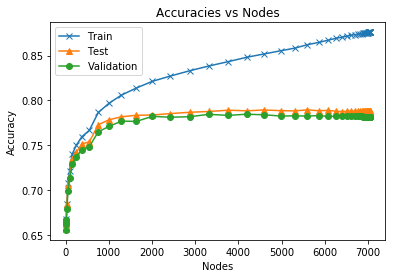

In [27]:
# Plot against number of nodes
LIM = 0
plt.plot(nodes[LIM:],TrainAccuracies[LIM:],marker='x')
plt.plot(nodes[LIM:],TestAccuracies[LIM:],marker='^')
plt.plot(nodes[LIM:],ValidationAccuracies[LIM:],marker='o')
plt.legend(['Train','Test','Validation'])
plt.ylabel('Accuracy')
plt.xlabel('Nodes')
plt.title('Accuracies vs Nodes')
# plt.show()
plt.savefig('accnode.png')

### Pruning

In [33]:
# gives the number of correct values after creating a node as leaf.
def Corrects(node,val):
    newR = copy.deepcopy(R)
    tmp = [l.startswith(node) for l in LEAF]
    newR[tmp] = val
    return len(np.where(newR==vY)[0])
CORR = np.vectorize(Corrects)

In [34]:
st = time.time()
TRAINSCORES = []
TESTSCORES = []
VALSCORES = []
NODES = []
i = 1
while(True):
    print("Iteration #"+str(i)+"")
    i+=1
    TRAINSCORES.append(root.Accuracy(X,Y))
    TESTSCORES.append(root.Accuracy(tX,tY))
    VALSCORES.append(root.Accuracy(vX,vY))
    NODES.append(root.count())
    R = np.asarray([root.predict(x) for x in vX])
    Correct = len(np.where(R == vY)[0])
    ind = -1
    (nodeslist,V) = root.locandval("")
    LEAF = [root.getLeaf(x,"") for x in vX]
    C = CORR(nodeslist,V)
    # If max correct values if less than equal to previous, then terminate the process.
    if(np.max(C) > Correct):
        ind = np.argmax(C)
        print("remove "+nodeslist[ind])
        root.delete(nodeslist[ind])
    else:
        break
print(time.time()-st)

Iteration #1
remove 100100
Iteration #2
remove 000011000011
Iteration #3
remove 000011000000000000
Iteration #4
remove 001
Iteration #5
remove 0000110100
Iteration #6
remove 00001001000
Iteration #7
remove 100001000000
Iteration #8
remove 00001111000000
Iteration #9
remove 00001110
Iteration #10
remove 0000110101
Iteration #11
remove 0000100010
Iteration #12
remove 10000100001001
Iteration #13
remove 00001011100
Iteration #14
remove 10000010000
Iteration #15
remove 000001000001000
Iteration #16
remove 10100000000000000
Iteration #17
remove 00001100101
Iteration #18
remove 00001100100001
Iteration #19
remove 100010000000
Iteration #20
remove 100000010000
Iteration #21
remove 01
Iteration #22
remove 0000110000100
Iteration #23
remove 0000101000010000
Iteration #24
remove 000000000001000000000000110000
Iteration #25
remove 0000101110100011
Iteration #26
remove 1011
Iteration #27
remove 1010010
Iteration #28
remove 1000010100
Iteration #29
remove 100001000110
Iteration #30
remove 100000001

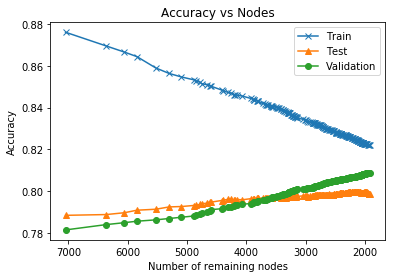

In [48]:
# Plot the data
plt.plot(NODES,TRAINSCORES,marker='x')
# plt.plot(nodes,TrainAccuracies)
plt.plot(NODES,TESTSCORES,marker='^')
# plt.plot(nodes,TestAccuracies)
plt.plot(NODES,VALSCORES,marker='o')
# plt.plot(nodes,ValidationAccuracies)
plt.gca().invert_xaxis()
plt.xlabel("Number of remaining nodes")
plt.ylabel("Accuracy")
plt.legend(['Train','Test','Validation'])
plt.title("Accuracy vs Nodes")
# plt.show()
plt.savefig('pruningacc.png')

In [57]:
# Train, Test and Validation Accuracy 
print("Train Accuracy: "+str(root.Accuracy(X,Y)))
print("Test Accuracy: "+str(root.Accuracy(tX,tY)))
print("Validation Accuracy: "+str(root.Accuracy(vX,vY)))

Train Accuracy: 0.822014123901
Test Accuracy: 0.798711232673
Validation Accuracy: 0.808733543482


### Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [90]:
n_est_grid = 100 * (np.arange(5)) + 50
max_features_grid = 0.2 * (np.arange(5)) + 0.1
min_sample_split_grid = 2 * (np.arange(5)+1)

In [91]:
OOBSCORE = []
TESTSCORE = []
VALSCORE = []
ST = time.time()
for n_est in n_est_grid:
    for max_features in max_features_grid:
        for min_sample_split in min_sample_split_grid:
            st = time.time()
            clf = RandomForestClassifier(n_estimators=n_est,min_samples_split=min_sample_split,max_features=max_features,bootstrap=True,oob_score=True,n_jobs=4)
            clf.fit(X,Y)
            OOBSCORE.append(clf.oob_score_)
            TestAccuracy = float(len(np.where(clf.predict(tX) == tY)[0]))/float(len(tY))
            ValidationAccuracy = float(len(np.where(clf.predict(vX) == vY)[0]))/float(len(vY))
            TESTSCORE.append(TestAccuracy)
            VALSCORE.append(ValidationAccuracy)
            print(time.time()-st,n_est,max_features,min_sample_split,clf.oob_score_,TestAccuracy,ValidationAccuracy)
print(time.time() - ST)

(9.782104969024658, 50, 0.1, 2, 0.7990048367406858, 0.7978767790088545, 0.7965881698498053)
(9.737708806991577, 50, 0.1, 4, 0.8021417644059153, 0.8018636131843679, 0.7991841275727796)
(9.685183048248291, 50, 0.1, 6, 0.8037952188895585, 0.8049232766213898, 0.8020582236232153)
(9.715170860290527, 50, 0.1, 8, 0.8055104847557678, 0.8062213156552779, 0.8044223994066383)
(9.659875869750977, 50, 0.1, 10, 0.8064067498029762, 0.8071484863937695, 0.8046541813461895)
(19.10282611846924, 50, 0.30000000000000004, 2, 0.7994066107273654, 0.7983867229150248, 0.7958928240311515)
(19.00933289527893, 50, 0.30000000000000004, 4, 0.8027444253859348, 0.8018636131843679, 0.7998331170035231)
(18.92991304397583, 50, 0.30000000000000004, 6, 0.804397879869578, 0.8042278985675212, 0.801641016132023)
(18.4462571144104, 50, 0.30000000000000004, 8, 0.8056804660578245, 0.8066849010245236, 0.804005191915446)
(19.22023582458496, 50, 0.30000000000000004, 10, 0.8061131457357873, 0.8066385424875991, 0.8057667346560357)
(2

(129.47276282310486, 350, 0.30000000000000004, 8, 0.809049186407677, 0.8075657132260906, 0.8052104580011126)
(130.45781779289246, 350, 0.30000000000000004, 10, 0.8103935839784896, 0.807843864447638, 0.8061375857593176)
(193.95040583610535, 350, 0.5, 2, 0.8020645001777077, 0.8002410643920078, 0.7982106434266641)
(193.11008191108704, 350, 0.5, 4, 0.8045987668629178, 0.8039033888090492, 0.8017337289078434)
(191.3924059867859, 350, 0.5, 6, 0.807488448997883, 0.805665013212183, 0.8033562024847024)
(192.5335738658905, 350, 0.5, 8, 0.807488448997883, 0.8064531083399008, 0.8047005377340998)
(191.03064608573914, 350, 0.5, 10, 0.8095436774682058, 0.8072412034676185, 0.8061839421472279)
(256.56321907043457, 350, 0.7000000000000001, 2, 0.8014618391976882, 0.8001947058550832, 0.7969126645651771)
(256.77788186073303, 350, 0.7000000000000001, 4, 0.8047996538562576, 0.8029298595336332, 0.801455590580382)
(260.88098096847534, 350, 0.7000000000000001, 6, 0.8073957319240338, 0.8039497473459738, 0.8021045

In [92]:
np.save('oobscoren.npy',OOBSCORE)

In [93]:
np.save('testscore.npy',TESTSCORE)

In [95]:
np.save('valscore.npy',VALSCORE)

In [100]:
I = np.argmax(OOBSCORE)
OPT_n_estimators_i = I / 25
OPT_n_estimators = n_est_grid[OPT_n_estimators_i]
I = I % 25
OPT_max_features_i = I / 5
OPT_max_features = max_features_grid[OPT_max_features_i]
I = I % 5
OPT_min_samples_split_i = I 
OPT_min_samples_split = min_sample_split_grid[OPT_min_samples_split_i]

In [101]:
print(OPT_n_estimators,OPT_max_features,OPT_min_samples_split)

(250, 0.1, 10)


In [54]:
# Optimal Classifier
clf = RandomForestClassifier(n_estimators=OPT_n_estimators,max_features=OPT_max_features,min_samples_leaf=OPT_min_samples_split,n_jobs=4,bootstrap=True,oob_score=True)
clf.fit(X,Y)    

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=4,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [56]:
# Train Accuracy
TrainAccuracy = float(len(np.where(clf.predict(X) == Y)[0]))/float(len(X))
# Test Accuracy
TestAccuracy = float(len(np.where(clf.predict(tX) == tY)[0]))/float(len(tX))
# Validation Accuracy
ValidationAccuracy = float(len(np.where(clf.predict(vX) == vY)[0]))/float(len(vX))
print("Training Accuracy: "+str(TrainAccuracy))
print("Out of bag Accuracy: "+str(clf.oob_score_))
print("Test Accuracy: "+str(TestAccuracy))
print("Validation Accuracy: "+str(ValidationAccuracy))

Training Accuracy: 0.828040733701
Out of bag Accuracy: 0.8097291116159041
Test Accuracy: 0.80645310834
Validation Accuracy: 0.805998516596


In [106]:
OOBSCORE_3d = np.reshape(OOBSCORE,(5,5,5))
TESTSCORE_3d = np.reshape(TESTSCORE,(5,5,5))
VALSCORE_3d = np.reshape(VALSCORE,(5,5,5))

### Parametere Sensitivity

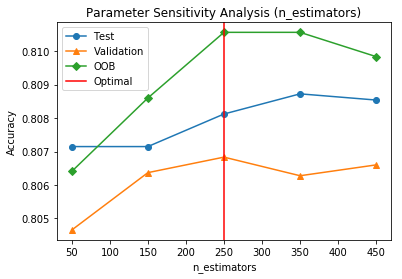

In [138]:
plt.plot(n_est_grid,TESTSCORE_3d[:,OPT_max_features_i,OPT_min_samples_split_i],marker='o')
plt.plot(n_est_grid,VALSCORE_3d[:,OPT_max_features_i,OPT_min_samples_split_i],marker='^')
plt.plot(n_est_grid,OOBSCORE_3d[:,OPT_max_features_i,OPT_min_samples_split_i],marker='D')
plt.axvline(x=OPT_n_estimators,color = 'r')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend(['Test','Validation','OOB','Optimal'])
plt.title('Parameter Sensitivity Analysis (n_estimators)')
plt.savefig('psanestimators.png')

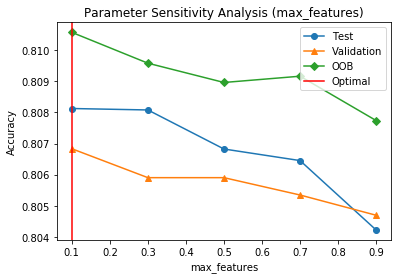

In [139]:
plt.plot(max_features_grid,TESTSCORE_3d[OPT_n_estimators_i,:,OPT_min_samples_split_i],marker = 'o')
plt.plot(max_features_grid,VALSCORE_3d[OPT_n_estimators_i,:,OPT_min_samples_split_i],marker = '^')
plt.plot(max_features_grid,OOBSCORE_3d[OPT_n_estimators_i,:,OPT_min_samples_split_i],marker='D')
plt.axvline(x=OPT_max_features,color = 'r')
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.legend(['Test','Validation','OOB','Optimal'])
plt.title('Parameter Sensitivity Analysis (max_features)')
plt.savefig('psamaxfeatures.png')

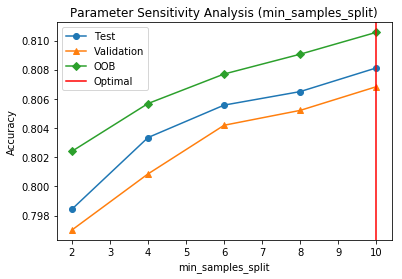

In [140]:
plt.plot(min_sample_split_grid,TESTSCORE_3d[OPT_n_estimators_i,OPT_max_features_i,:],marker = 'o')
plt.plot(min_sample_split_grid,VALSCORE_3d[OPT_n_estimators_i,OPT_max_features_i,:],marker = '^')
plt.plot(min_sample_split_grid,OOBSCORE_3d[OPT_n_estimators_i,OPT_max_features_i,:],marker = 'D')
plt.axvline(x=OPT_min_samples_split,color = 'r')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.legend(['Test','Validation','OOB','Optimal'])
plt.title('Parameter Sensitivity Analysis (min_samples_split)')
plt.savefig('psaminsample.png')